
### Import thư viện

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display

In [2]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cpu


### Tải bộ dataset

In [3]:
dataset_path = 'flowers'

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=40),

    transforms.Resize(300),
    transforms.CenterCrop(256),

    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
train_size = int(len(dataset)*0.7)
test_size = len(dataset) - train_size
print(train_size, test_size)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_size, test_size))

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=False,
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
)

3361 1441


### Vẽ một số mẫu dữ liệu

In [4]:
figsize = (16,16)

def PlotSamples(dataloader, title='Images'):
    sample_data = next(iter(dataloader))[0].to(device)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        sample_data, padding=2, normalize=True
    ).cpu(), (1,2,0)))
    
    
def PlotClass(dataloader, mclass, title='Images', num=64):
    ret = []
    
    for data in dataloader.dataset:
        if data[1] == mclass:
            ret.append(data[0])
            
            if len(ret) == num:
                break
    
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        ret, padding=2, normalize=True
    ).cpu(), (1,2,0)))
    

In [6]:
# len(dataset)
PlotSamples(train_dataloader)

### Tạo model

In [5]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3), nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

        ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(4096, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)
        ).to(device)
        
    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


model = MyModel().to(device)
summary(model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
              ReLU-2         [-1, 16, 254, 254]               0
            Conv2d-3         [-1, 16, 252, 252]           2,320
              ReLU-4         [-1, 16, 252, 252]               0
         MaxPool2d-5         [-1, 16, 126, 126]               0
            Conv2d-6         [-1, 32, 124, 124]           4,640
              ReLU-7         [-1, 32, 124, 124]               0
            Conv2d-8         [-1, 32, 122, 122]           9,248
              ReLU-9         [-1, 32, 122, 122]               0
        MaxPool2d-10           [-1, 32, 61, 61]               0
           Conv2d-11           [-1, 64, 59, 59]          18,496
             ReLU-12           [-1, 64, 59, 59]               0
           Conv2d-13           [-1, 64, 57, 57]          36,928
             ReLU-14           [-1, 64,

### Training

In [6]:
lr = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [8]:
def Train(epoch, print_every=50):
    total_loss = 0
    start_time = time()
    
    accuracy = []
    
    for i, batch in enumerate(train_dataloader, 1):
        minput = batch[0].to(device) 
        target = batch[1].to(device) 
        
        moutput = model(minput)
        
        loss = criterion(moutput, target)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        argmax = moutput.argmax(dim=1)
        accuracy.append((target==argmax).sum().item() / target.shape[0])

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time 
            ))
    
    return total_loss / len(train_dataloader)

### Testing

In [9]:
def Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []
    
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            minput = batch[0].to(device)
            target = batch[1].to(device)
            moutput = model(minput)

            loss = criterion(moutput, target)
            total_loss += loss.item()
            
            argmax = moutput.argmax(dim=1)
            accuracy.append((target==argmax).sum().item() / target.shape[0])
            
    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return total_loss/len(test_dataloader)

### Train 30 lần

In [10]:
Test(0)

train_loss = []
test_loss = []

for epoch in range(1, 31):
    train_loss.append(Train(epoch,200))
    test_loss.append(Test(epoch))

    print('\n')
    
    if epoch % 10 == 0:
        torch.save(model, 'model_'+str(epoch)+'.pth')

Epoch: [0], Test Loss: 1.3853, Accuracy: 0.27, Time: 53.25 sec
Epoch: [1]/(200/211), Train Loss: 1.1195, Accuracy: 0.36, Time: 263.26 sec
Epoch: [1], Test Loss: 1.1651, Accuracy: 0.43, Time: 51.79 sec


Epoch: [2]/(200/211), Train Loss: 1.0868, Accuracy: 0.47, Time: 260.69 sec
Epoch: [2], Test Loss: 1.0796, Accuracy: 0.46, Time: 51.04 sec


Epoch: [3]/(200/211), Train Loss: 1.0025, Accuracy: 0.48, Time: 264.51 sec
Epoch: [3], Test Loss: 1.0375, Accuracy: 0.47, Time: 52.03 sec


Epoch: [4]/(200/211), Train Loss: 1.1459, Accuracy: 0.51, Time: 256.65 sec
Epoch: [4], Test Loss: 0.9750, Accuracy: 0.57, Time: 52.59 sec


Epoch: [5]/(200/211), Train Loss: 1.0117, Accuracy: 0.58, Time: 256.66 sec
Epoch: [5], Test Loss: 0.9536, Accuracy: 0.56, Time: 52.49 sec


Epoch: [6]/(200/211), Train Loss: 1.0037, Accuracy: 0.59, Time: 266.14 sec
Epoch: [6], Test Loss: 0.9652, Accuracy: 0.58, Time: 54.30 sec


Epoch: [7]/(200/211), Train Loss: 0.8373, Accuracy: 0.60, Time: 259.50 sec
Epoch: [7], Test Loss:

KeyboardInterrupt: 

### Training and Testing loss

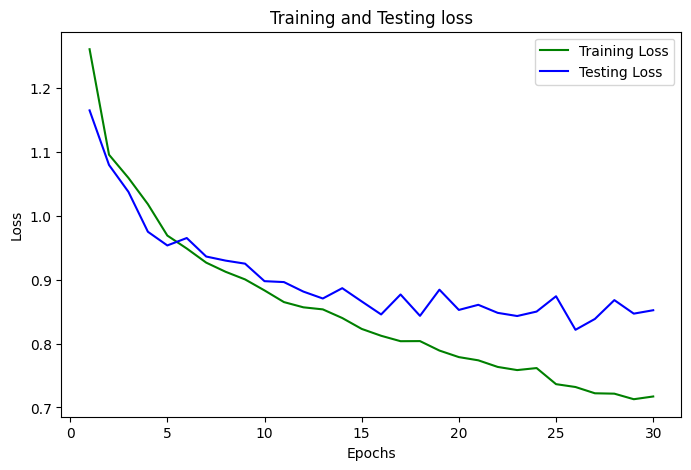

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss)+1), train_loss, 'g', label='Training Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, 'b', label='Testing Loss')

plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test on some random images

In [7]:
translate = {
    # "daisy": "hoa cúc", 
    # "dandelion": "bồ công anh", 
    "lotus": "Hoa sen", 
    # "orchid-flower": "Hoa lan", 
    # "peach-blossom": "Hoa đào", 
    # "plum-flower": "Hoa mận", 
    "rose": "hoa hồng", 
    "sunflower": "hoa hướng dương", 
    "tulip": "hoa tulip",
    # "violet-flower": "Hoa violet",
}

translate = {x:translate[x] for x in train_dataloader.dataset.dataset.classes}

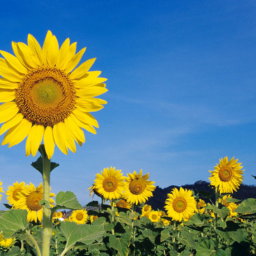

hoa hướng dương : 99 % 




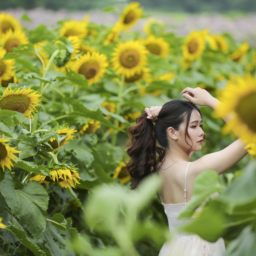

hoa hướng dương : 75 % 




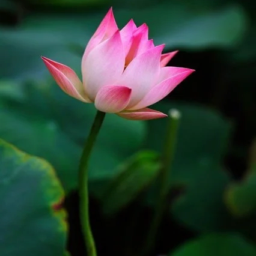

Hoa sen : 68 % 




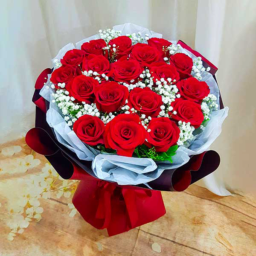

hoa hồng : 65 % 




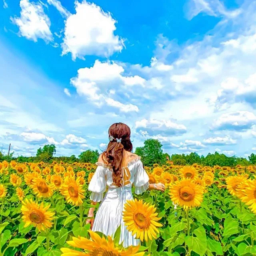

hoa hướng dương : 79 % 




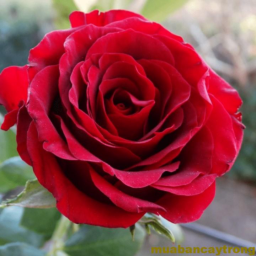

hoa hồng : 80 % 




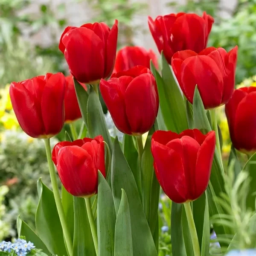

hoa tulip : 99 % 




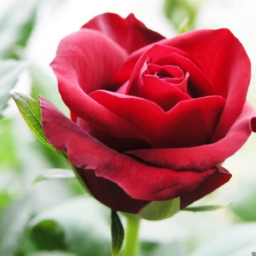

hoa hồng : 88 % 




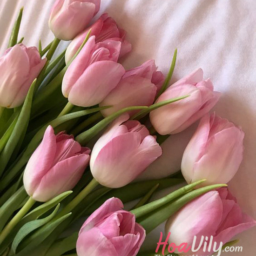

hoa tulip : 55 % 




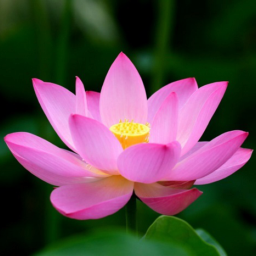

Hoa sen : 95 % 




In [15]:
# Sử dụng model 30 đã lưu
model = torch.load('model_30.pth', map_location=device) 
model.eval()


denormalize = transforms.Compose([
    transforms.Normalize(mean = -mean/std, std = 1./std),
    transforms.ToPILImage()
])


with torch.no_grad():

    for impath in os.listdir('test_images'):
        try:
            image = Image.open(f'test_images/{impath}')
        except:
            continue

        image = transforms.Compose([
            transforms.Resize(256),  
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])(image)

        image_tensor = image.view(1,3,256,256).to(device)

        moutput = model(image_tensor)
        moutput = nn.Softmax(dim=1)(moutput)[0]*100
        
        idx = moutput.argmax().data.item()
        oclass = list(translate.keys())[idx]
        moutput = moutput.int().data.cpu().numpy()

        display(denormalize(image))
        print(translate[oclass], ':', moutput[idx], '%', '\n\n')

model.train()
pass